# Regressions


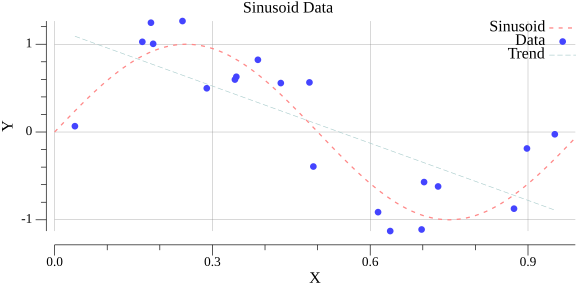

In [1]:
// deno-lint-ignore-file
import pl from "npm:nodejs-polars";
import plot from "../plot/mod.ts";

const data = await Deno.readTextFile("assets/X_Y_Sinusoid_Data.csv");
const df = pl.readCSV(data, { sep: "," });

const real = pl.DataFrame({ x: new Array(100).fill(0).map((_, i) => i / 100)}).select(
    pl.col('x'),
    pl.col('x').mul(2).mul(3.14).sin().alias('y')
);

const draw = (x, y, title = "Sinusoid Data") => 
  plot.DrawPlot(
      { 
          title,
          width: 6,
          height: 3,
          XLabel: "X", 
          YLabel: "Y", 
      }, 
      { type: "line", data: [real.x, real.y], legend: "Sinusoid", lineDashes: [3, 4], lineColor: "#ff8888", lineWidth: 1 },
      { type: "scatter", data: [x, y], legend: "Data", lineDashes: [3, 4], lineWidth: 2, glyphColor: "#4444ff", glyphShape: "circle" },
      { type: "trend", data: [x, y], legend: "Trend", lineDashes: [4, 2], lineColor: '#aacccc', lineWidth: .5 },
  );

  const comparePredicted = (x, y, predicted) => plot.DrawPlot(
    { 
        width: 7,
        height: 4,
        XLabel: "X", 
        YLabel: "Y", 
    }, 
    { type: "line", data: [real.x, real.y], legend: "Sinusoid", lineDashes: [3, 4], lineColor: "#ff8888", lineWidth: 1 },
    { type: "linePoints", data: [x, y], legend: "Test Data", lineDashes: [3, 4], lineColor: "#8888ff",  glyphColor: "#4444ff", glyphShape: "circle" },
    { type: "linePoints", data: [x, predicted], lineWidth: .5, legend: "Predicted",  glyphColor: '#f00', glyphShape: "pyramid" },
);


draw(df.x, df.y);

# Polynomial Tranformation

First we try to predict values without polynomial transformation:

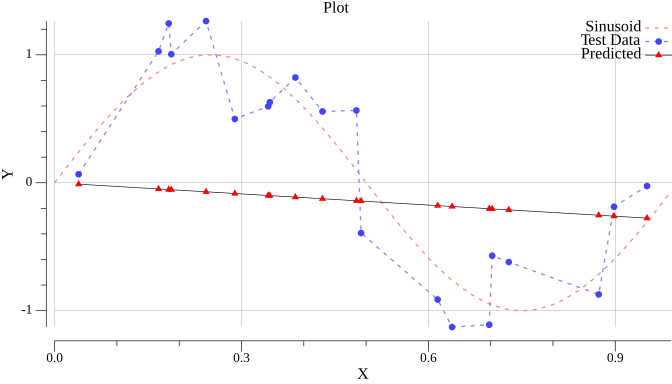

In [2]:
import regr from '../regr/mod.ts';

const linregWoPoly = regr.Linear();

linregWoPoly.fit(df.drop('y').rows(), df.select('y').rows());
const predWoPoly = linregWoPoly.predict(df.drop('y').rows());

comparePredicted(df.x, df.y, predWoPoly);

Now augment our dataset with high degree polynomial:

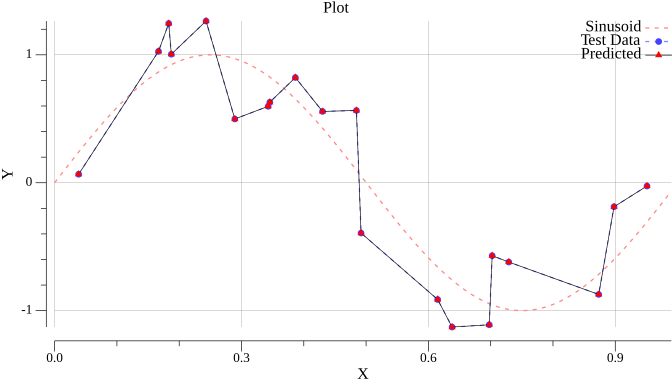

In [3]:
import { polynomialTransform } from '../encoding.ts';



const polyFeatures = polynomialTransform(df.drop('y'), 36, false, false)

const [polyX, polyY] = [polyFeatures, df.select('y')]

const linregPoly = regr.Linear();

linregPoly.fit(polyX.rows(), polyY.rows());
const predY = linregPoly.predict(polyX.rows());

comparePredicted(df.x, df.y, predY);


In [4]:
linregPoly.score(df.select('y').rows(), pl.DataFrame({"py":predY}).rows());

0.9999999469410812

# ElasticNet

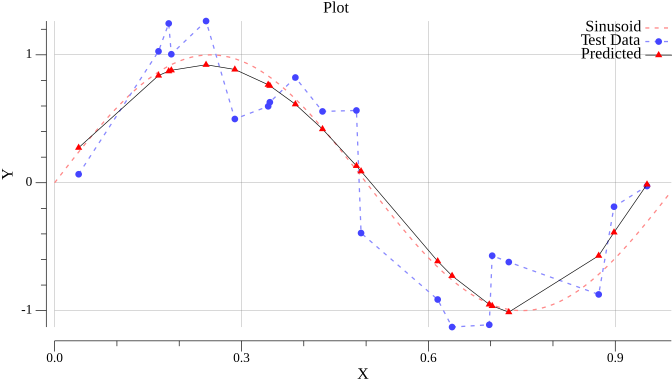

In [5]:
const elasticNetPoly = regr.ElasticNet(1000, 0.0001);
elasticNetPoly.fit(polyX.rows(), polyY.rows());
const predEnetY = elasticNetPoly.predict(polyX.rows());

comparePredicted(df.x, df.y, predEnetY);

# Lasso

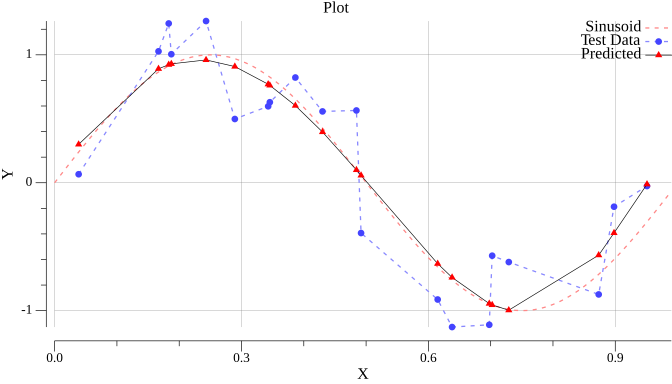

In [6]:
const lassoPoly = regr.Lasso(1000, 0.0001);
lassoPoly.fit(polyX.rows(), polyY.rows());
const predLassoY = lassoPoly.predict(polyX.rows());

comparePredicted(df.x, df.y, predLassoY);

In [7]:
lassoPoly.score(df.select('y').rows(), pl.DataFrame({"py":predLassoY}).rows());


0.8637104981289901

# Logistic Regression

Logistic regression is applicable for classification problems when there are linear relationships in the data.

For example we'll use a simple linear pattern for predictions:

In [8]:
const clsDf = pl.DataFrame({ 
        x: new Array(100).fill(0).map((_, i) => i ),
        x2: new Array(100).fill(0).map((_, i) => i % 2 - 1 + Math.random() / 100),
        x3: new Array(100).fill(0).map((_, i) => i % 2 - i % 3 + Math.random() / 100),
    }).select(
    pl.all(),
    pl.col('x').modulo(2).eq(0).add(0).alias('is_even'),
);
clsDf.head(10);

x x2 x3 is_even 0 -0.9906467224227306 0.00261179419023964 1 1 0.00202764718654894 0.0013126936809724655 0 2 -0.9972687463767552 -1.9905576758692132 1 3 0.009024117668298463 1.0021275936361942 0 4 -0.9968599379688912 -0.9947633704461447 1 5 0.0019298798125454942 -0.9913865823439642 0 6 -0.9967558047825875 0.00801993440722967 1 7 0.007736464312311071 0.00034330022067074583 0 8 -0.9959077406033643 -1.994011690184521 1 9 0.002684616942261051 1.0072230674765243 0

Notice that I left `x` in training data which is a continuos sequence that couln't be generalized by this model, however the model should guess a correct class in most cases. 

In [9]:
const drawBin = (x1, y1, t = "Example") => {
    const xTrue = clsDf.x.toArray().map((v, i) => v % 2)
    const yTrue = clsDf.is_even.toArray()
    y1 = y1.map((v, i) => v + i * 0.02)
    x1 = x1.map((v, i) => v % 2)
    return plot.DrawPlot(
        { 
            title: "",
            width: 2.5,
            height: 2,
            XLabel: "X", 
            YLabel: "Y", 
        }, 
        { type: "scatter", data: [xTrue, yTrue], lineDashes: [3, 4], glypRadius: 12, glyphColor: "#00f", glyphShape: "ring" },
        { type: "scatter", data: [x1, y1], legend: t, lineDashes: [3, 4], glypRadius: 3, glyphColor: "#f00", glyphShape: "ring" },
    );
}


In [10]:
import {trainTestSplit} from "../split.ts";


const {testX, trainX, testY, trainY} = trainTestSplit(clsDf, 0.05, true, "is_even");

const drawTestBin = () => drawBin(testX.x.toArray(), testY.is_even.toArray(), "Test Data");


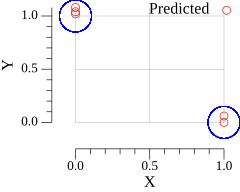

In [11]:
const logreg = regr.Logistic({
    epochs: 5000,
    learningRate: 0.001,
});
logreg.fit(trainX.rows(), trainY.rows());

const predLogReg = logreg.predict(testX.rows());

const yPred1 = predLogReg.map((x) => x[0]);

drawBin(
    testX.x.toArray(), 
    yPred1,
    "Predicted"
);

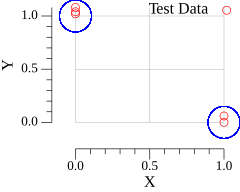

In [12]:
drawTestBin()

In [13]:
console.log(yPred1, "should be",  testY.is_even.toArray());

[ 0, 1, 1, 0, 1 ] should be [ 0, 1, 1, 0, 1 ]


In [14]:
logreg.loss();

1.6635532311438688